In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import emoji
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report ,accuracy_score,confusion_matrix

In [2]:
name_columns=['polarity','title_review','text_review']
df=pd.read_csv('/kaggle/input/amazon-reviews/test.csv',header=None,names=name_columns)
df.head()

,polarity,title_review,text_review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [3]:
df.shape

(400000, 3)

In [4]:
df.isnull().sum()

polarity         0
title_review    24
text_review      0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.duplicated().sum()

0

In [7]:
df.shape

(399976, 3)

In [8]:
df["full_review"] = df["title_review"] + " " + df["text_review"]
df.head()

,polarity,title_review,text_review,full_review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou..."
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...


In [9]:
df['polarity']=df['polarity'].replace({2:1,1:0})
df.head()

,polarity,title_review,text_review,full_review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...


In [10]:
def lowercasing(text):
    return text.lower()

def remove_noise(text):
    # Remove punctuation, numbers, and symbols 
    return re.sub(r'[^a-zA-Z\s]', '', text)

def tokenization(text):
    return word_tokenize(text)
    
def get_max_len(texts):
  return max([len(text) for text in texts])   

def remove_stopwords(tokens):
    stop_words=set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def stemming(tokens):
    stemmer=PorterStemmer()
    [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

In [11]:
df['cleaned_review'] = df['full_review'].apply(lowercasing)

In [12]:
df['cleaned_review'] = df['cleaned_review'].apply(remove_noise)

In [13]:
# Remove emojis
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: emoji.demojize(x))

In [14]:
df['cleaned_review'] = df['cleaned_review'].apply(tokenization)

In [15]:
sent_length = get_max_len(df['cleaned_review'])
print(sent_length)

228


In [16]:
df['cleaned_review'] = df['cleaned_review'].apply(remove_stopwords)

In [17]:
df['cleaned_review'] = df['cleaned_review'].apply(stemming)

In [18]:
df.head()

,polarity,title_review,text_review,full_review,cleaned_review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...,great cd lovely pat one great voices generatio...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...,one best game music soundtracks game didnt rea...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...,batteries died within year bought charger jul ...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou...",works fine maha energy better check maha energ...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...,great nonaudiophile reviewed quite bit combo p...


In [19]:
voc_size = 10000
token = Tokenizer(num_words=voc_size , oov_token='UNK')
token.fit_on_texts(df['cleaned_review'])

In [20]:
x = df['cleaned_review']
y = df['polarity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
# Convert texts to sequences
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

In [22]:
# Pad sequences to the same length
x_train = pad_sequences(x_train_seq, maxlen=sent_length, padding='post', truncating='post')  
x_test = pad_sequences(x_test_seq, maxlen=sent_length, padding='post', truncating='post')

In [23]:
# LSTM Model

embedding_dim = 100

model = Sequential()
model.add(Embedding(voc_size+1, embedding_dim, mask_zero=True, input_length=sent_length))

model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, sent_length))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 228, 100)       │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 228, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 228, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 228, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 228, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,110,629 (4.24 MB)

 Trainable params: 1,110,565 (4.24 MB)

 Non-trainable params: 64 (256.00 B)

In [24]:
# Callbacks
e_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='max',restore_best_weights=True)
callbacklist = [e_stopping]

In [25]:
# Training
hist = model.fit(x_train, y_train, batch_size=256, epochs=30, validation_split=0.2, callbacks=callbacklist)

Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1252s 1s/step - accuracy: 0.8081 - loss: 0.4166 - val_accuracy: 0.8825 - val_loss: 0.2907
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1240s 1s/step - accuracy: 0.8912 - loss: 0.2749 - val_accuracy: 0.8958 - val_loss: 0.2579
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1242s 1s/step - accuracy: 0.9035 - loss: 0.2466 - val_accuracy: 0.8998 - val_loss: 0.2521
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1237s 1s/step - accuracy: 0.9129 - loss: 0.2269 - val_accuracy: 0.9010 - val_loss: 0.2479
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1235s 1s/step - accuracy: 0.9191 - loss: 0.2115 - val_accuracy: 0.9017 - val_loss: 0.2472
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1234s 1s/step - accuracy: 0.9250 - loss: 0.1972 - val_accuracy: 0.9008 - val_loss: 0.2494
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1239s 1s/step - accuracy: 0.9309 - loss: 0.1842 - val_accuracy: 0.8994 - val_loss: 0.2630
Epoch 8/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1244s 1s/step - accuracy: 0.9356 -

In [26]:
sns.set()
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochss=range(1,len(loss)+1)

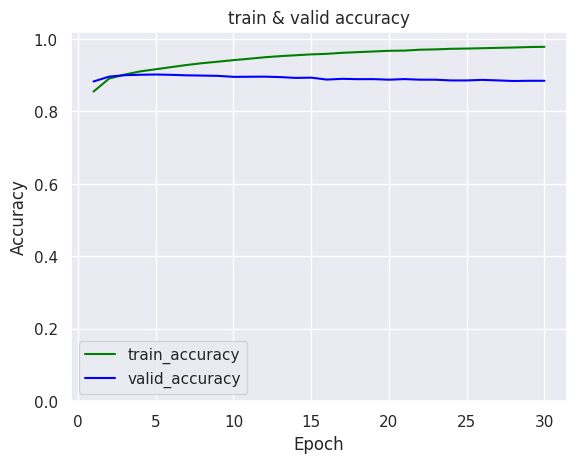

In [27]:
plt.plot(epochss,acc,color='green',label='train_accuracy')
plt.plot(epochss,val_acc,color='blue',label='valid_accuracy')
plt.title('train & valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0,1.02)
plt.show()

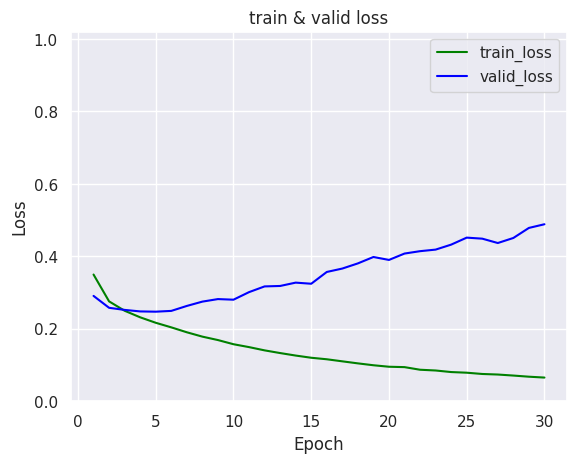

In [28]:
plt.figure()
plt.plot(epochss,loss,color='green',label='train_loss')
plt.plot(epochss,val_loss,color='blue',label='valid_loss')
plt.title('train & valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [29]:
model.evaluate(x_train,y_train)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2023s 202ms/step - accuracy: 0.9902 - loss: 0.0372


[0.11948388069868088, 0.9709857106208801]

In [30]:
model.evaluate(x_test,y_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 502s 201ms/step - accuracy: 0.8866 - loss: 0.4778


[0.4892386198043823, 0.8853817582130432]

In [31]:
y_pred = model.predict(x_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 500s 200ms/step


In [32]:
y_pred = (y_pred > 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     40010
           1       0.88      0.89      0.89     39986

    accuracy                           0.89     79996
   macro avg       0.89      0.89      0.89     79996
weighted avg       0.89      0.89      0.89     79996



<Axes: >

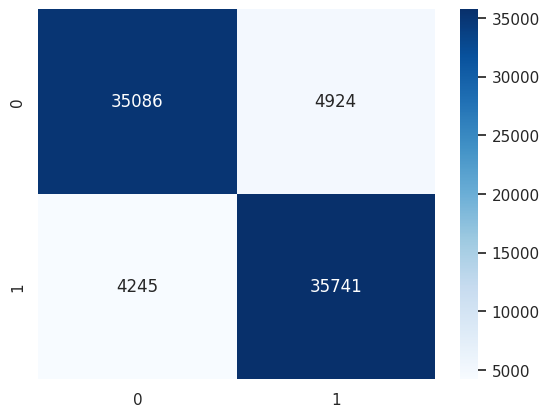

In [33]:
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues')